In [1]:
from google.colab import drive
from google.colab import files
import torch
import os
import torch.nn as nn
import shutil
import cv2
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from collections import defaultdict
from torchvision.utils import make_grid

drive.mount('/content/drive')
workspace_path = '/content/drive/MyDrive/GreyToColour/'
os.chdir(workspace_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [2]:
main_folder = "/content/drive/MyDrive/GreyToColour/data/data/"

# Klasörlerin isimlerini belirtin
folders = ["Flowers", "Cars"]

total_count=0

for folder_name in folders:
    folder_path = os.path.join(main_folder, folder_name)
    sub_folders = ["grey", "colour"]
    for sub_folder_name in sub_folders:
        sub_folder_path = os.path.join(folder_path, sub_folder_name)
        files = os.listdir(sub_folder_path)
        total_count+=len(files)
dataset_name = "Flowers + Cars"
print(f"{dataset_name} Veri seti Boyutu:", total_count)


Flowers + Cars Veri seti Boyutu: 800


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.files_grey = sorted(os.listdir(os.path.join(root, 'grey')))
        self.files_colour = sorted(os.listdir(os.path.join(root, 'colour')))
        self.root_grey = os.path.join(root, 'grey')
        self.root_colour = os.path.join(root, 'colour')

    def __len__(self):
        return len(self.files_grey)

    def __getitem__(self, index):
        img_grey = Image.open(os.path.join(self.root_grey, self.files_grey[index])).convert('RGB')
        img_colour = Image.open(os.path.join(self.root_colour, self.files_colour[index])).convert('RGB')

        if self.transform:
            img_grey = self.transform(img_grey)
            img_colour = self.transform(img_colour)

        #print(img_grey.shape)
        #print(img_colour.shape)

        img_np_grey = np.array(img_grey.permute(1, 2, 0))  # Convert to HWC format
        img_np_colour = np.array(img_colour.permute(1, 2, 0))  # Convert to HWC format

        img_np_grey = (img_np_grey * 255).astype(np.uint8)
        img_np_colour = (img_np_colour * 255).astype(np.uint8)

        #print(img_np_grey.shape)
        #cv2_imshow(img_np_grey)

        #print(img_np_colour.shape)
        #cv2_imshow(img_np_colour)

        #print(type(img_np_grey))
        #print(type(img_np_colour))


        return {'grey':img_grey, 'colour':img_colour}


(128, 128, 3)


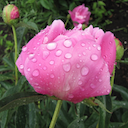

In [5]:
from google.colab.patches import cv2_imshow
root_dir = '/content/drive/MyDrive/GreyToColour/gray_to_colour_data/'

# burada normalde grayscale görüntünün channel sayısı kaç onu kontrol ettim
# I checked the channel size of grayscale image before the transformation
img = cv2.imread('/content/drive/MyDrive/GreyToColour/gray_to_colour_data/train/colour/0040.png')
print(img.shape)
cv2_imshow(img)

# Eğitim veri seti
train_dataset = ImageDataset(root=os.path.join(root_dir, 'train'), transform=transform)
img = train_dataset[250]
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Doğrulama veri seti
val_dataset = ImageDataset(root=os.path.join(root_dir, 'validation'), transform=transform)
img = val_dataset[3]
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Test veri seti
test_dataset = ImageDataset(root=os.path.join(root_dir, 'test'), transform=transform)
img = test_dataset[7]
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
class Encoder(nn.Module):
    def __init__(self, in_size, out_size):
        super(Encoder, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, stride=2, padding=1),
                  nn.LeakyReLU(0.2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, in_size, out_size):
        super(Decoder, self).__init__()
        layers = [
            #nn.ConvTranspose2d(in_size, out_size, 4, stride=2, padding=1, bias=False),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_size, out_size, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_size),
            nn.ReLU(inplace=True)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # print("Shape of x:", x.shape)
        # print("Shape of skip_input:", skip_input.shape)

        # x = F.interpolate(x, size=skip_input.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat((x, skip_input), 1)
        return x

In [7]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = Encoder(in_channels, 64)
        self.down2 = Encoder(64, 128)
        self.down3 = Encoder(128, 256)
        self.down4 = Encoder(256, 512)
        self.down5 = Encoder(512, 512)
        self.down6 = Encoder(512, 512)
        self.down7 = Encoder(512, 512)
        self.down8 = Encoder(512, 512)

        self.up1 = Decoder(512, 512)
        self.up2 = Decoder(1024, 512)
        self.up3 = Decoder(1024, 512)
        self.up4 = Decoder(1024, 512)
        self.up5 = Decoder(1024, 256)
        self.up6 = Decoder(512, 128)
        self.up7 = Decoder(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)

        return u8

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels_A=3, in_channels_B=3):
        super(Discriminator, self).__init__()

        # self.img_A_conv = nn.Conv2d(in_channels_A, in_channels_B, kernel_size=1)

        def discriminator_block(in_filters, out_filters):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels_B * 2, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img_A, img_B):
        #img_A = self.img_A_conv(img_A)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [9]:
image1 = torch.rand((1, 3, 256, 256))
image2 = torch.rand((1, 3, 256, 256))

out_channels = 3
discriminator = Discriminator()
k = discriminator(image1, image2)
print(k.shape)

torch.Size([1, 1, 16, 16])


In [10]:
loss_comparison = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()
generator = GeneratorUNet()

In [11]:
def discriminator_training(inputs, targets, discriminator_opt):
  discriminator_opt.zero_grad()

  # passing real image and getting loss
  output = discriminator(inputs, targets)
  label = torch.ones(size=output.shape, dtype=torch.float, device=device)

  real_loss = loss_comparison(output, label)

  # passing generated image and getting loss

  gen_image = generator(inputs).detach()

  fake_output = discriminator(inputs, gen_image)
  fake_label = torch.zeros(size=fake_output.shape, dtype=torch.float, device=device)

  fake_loss = loss_comparison(fake_output, fake_label)

  total_loss = (real_loss + fake_loss)/2

  total_loss.backward()

  discriminator_opt.step()

  return total_loss

In [12]:
def generator_training(inputs, targets, generator_opt, L1_lambda):
  generator_opt.zero_grad()

  generated_image = generator(inputs)
  disc_output = discriminator(generated_image, targets)
  desired_output = torch.ones(size=disc_output.shape, dtype=torch.float, device=device)
  # desired_output = torch.ones_like(disc_output)

  # generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * torch.abs(generated_image-targets).sum()
  generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * L1_loss(generated_image, targets)
  generator_loss.backward()
  generator_opt.step()

  return generator_loss, generated_image

In [13]:

Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * 0.5 + 0.5

In [14]:

def print_images(image_tensor, num_images):

    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [15]:
L1_lambda = 50
num_epochs = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
discriminator_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
generator_opt = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

discriminator = discriminator.to(device)
generator = generator.to(device)

Epoch: 1/100 Loss D: 0.6836769580841064, Loss G: 5.601916790008545


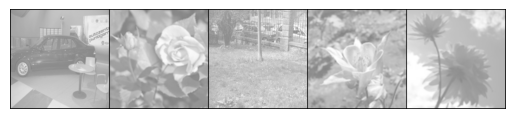

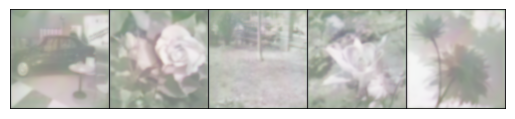

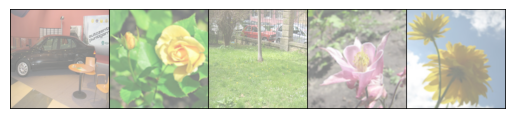

Validation Loss: 0.6998425960540772
Epoch: 2/100 Loss D: 0.6522754430770874, Loss G: 4.845288276672363
Validation Loss: 0.6988498091697692
Epoch: 3/100 Loss D: 0.597274661064148, Loss G: 4.976761817932129
Validation Loss: 0.6910839557647706
Epoch: 4/100 Loss D: 0.7101747989654541, Loss G: 3.2374444007873535
Validation Loss: 0.7004831790924072
Epoch: 5/100 Loss D: 0.6827528476715088, Loss G: 4.3454999923706055
Validation Loss: 0.6983695745468139
Epoch: 6/100 Loss D: 0.6212433576583862, Loss G: 3.601196527481079


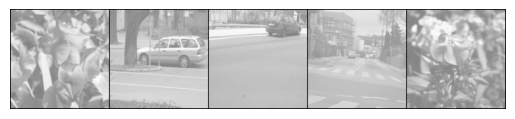

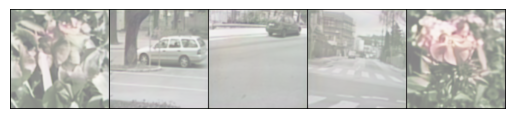

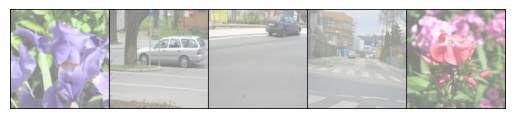

Validation Loss: 0.6971513271331787
Epoch: 7/100 Loss D: 0.659522294998169, Loss G: 3.404099225997925
Validation Loss: 0.6952711343765259
Epoch: 8/100 Loss D: 0.6488416790962219, Loss G: 3.9957094192504883
Validation Loss: 0.6947628498077393
Epoch: 9/100 Loss D: 0.6909670829772949, Loss G: 4.039888858795166
Validation Loss: 0.6940451025962829
Epoch: 10/100 Loss D: 0.6933248043060303, Loss G: 2.8460259437561035
Validation Loss: 0.693952989578247
Epoch: 11/100 Loss D: 0.6725635528564453, Loss G: 4.1142354011535645


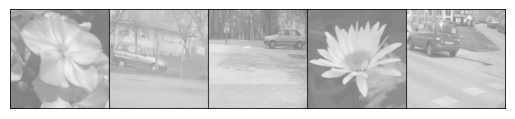

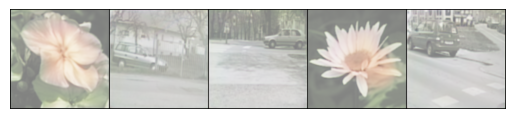

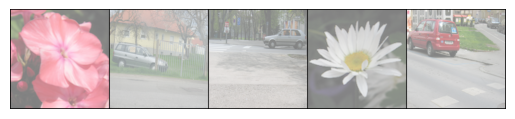

Validation Loss: 0.6974878072738647
Epoch: 12/100 Loss D: 0.650138258934021, Loss G: 3.3339293003082275
Validation Loss: 0.6953429818153382
Epoch: 13/100 Loss D: 0.6708306074142456, Loss G: 3.6524627208709717
Validation Loss: 0.6963211417198181
Epoch: 14/100 Loss D: 0.7182875871658325, Loss G: 3.015341281890869
Validation Loss: 0.6964828133583069
Epoch: 15/100 Loss D: 0.6465822458267212, Loss G: 3.649768352508545
Validation Loss: 0.6936795711517334
Epoch: 16/100 Loss D: 0.684662938117981, Loss G: 2.789149284362793


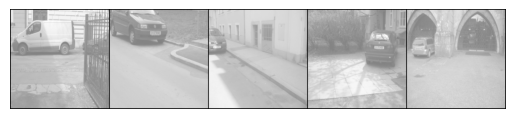

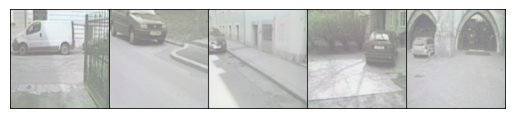

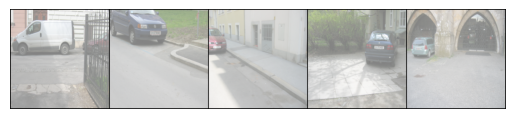

Validation Loss: 0.6933701753616333
Epoch: 17/100 Loss D: 1.7395159006118774, Loss G: 3.0642588138580322
Validation Loss: 0.7003729701042175
Epoch: 18/100 Loss D: 0.6927026510238647, Loss G: 2.4628396034240723
Validation Loss: 0.6927686333656311
Epoch: 19/100 Loss D: 0.6956494450569153, Loss G: 3.163025379180908
Validation Loss: 0.6960304856300354
Epoch: 20/100 Loss D: 0.7008228302001953, Loss G: 3.2957189083099365
Validation Loss: 0.6933075070381165
Epoch: 21/100 Loss D: 0.6382428407669067, Loss G: 4.293314456939697


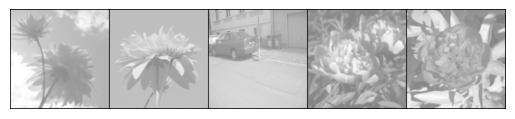

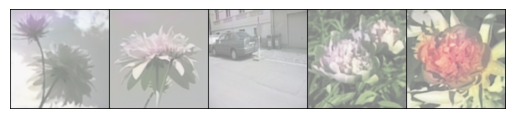

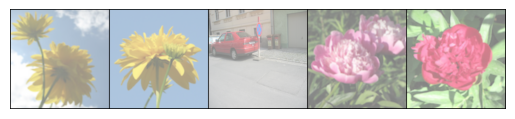

Validation Loss: 0.6978732466697692
Epoch: 22/100 Loss D: 0.689360499382019, Loss G: 3.547445774078369
Validation Loss: 0.6978240728378295
Epoch: 23/100 Loss D: 0.6250245571136475, Loss G: 3.3479387760162354
Validation Loss: 0.6929633975028991
Epoch: 24/100 Loss D: 0.686440110206604, Loss G: 3.3245158195495605
Validation Loss: 0.6950893878936768
Epoch: 25/100 Loss D: 0.6052312254905701, Loss G: 3.1542673110961914
Validation Loss: 0.6973111867904663
Epoch: 26/100 Loss D: 0.6810243129730225, Loss G: 2.9139461517333984


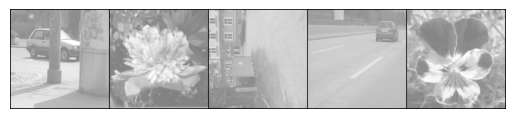

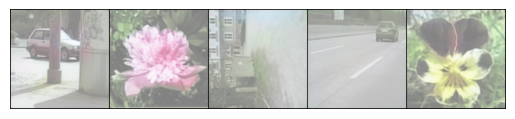

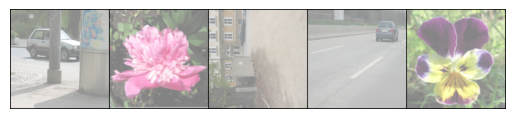

Validation Loss: 0.694819164276123
Epoch: 27/100 Loss D: 0.7010772228240967, Loss G: 2.5804100036621094
Validation Loss: 0.6942485690116882
Epoch: 28/100 Loss D: 0.6750311851501465, Loss G: 3.121713161468506
Validation Loss: 0.6957900285720825
Epoch: 29/100 Loss D: 0.7083910703659058, Loss G: 2.577090263366699
Validation Loss: 0.694669532775879
Epoch: 30/100 Loss D: 0.6785972118377686, Loss G: 2.4899487495422363
Validation Loss: 0.6953959584236145
Epoch: 31/100 Loss D: 0.6854175329208374, Loss G: 3.037294387817383


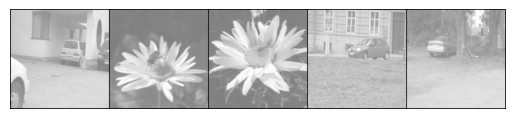

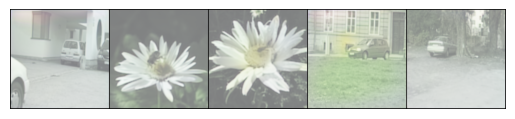

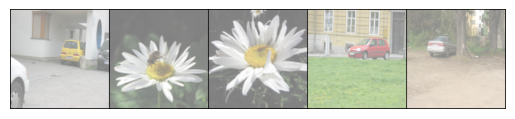

Validation Loss: 0.6946783542633057
Epoch: 32/100 Loss D: 0.6852782964706421, Loss G: 3.1862165927886963
Validation Loss: 0.6915239334106446
Epoch: 33/100 Loss D: 0.7177313566207886, Loss G: 2.6853199005126953
Validation Loss: 0.6936760067939758
Epoch: 34/100 Loss D: 0.6987023949623108, Loss G: 2.491194009780884
Validation Loss: 0.6899320363998414
Epoch: 35/100 Loss D: 0.6656321287155151, Loss G: 2.829982280731201
Validation Loss: 0.6933895230293274
Epoch: 36/100 Loss D: 0.7003889679908752, Loss G: 2.577732563018799


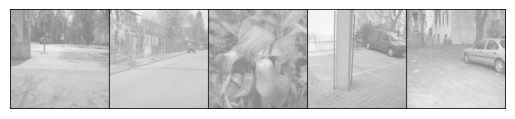

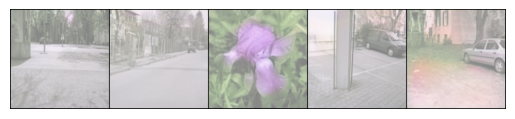

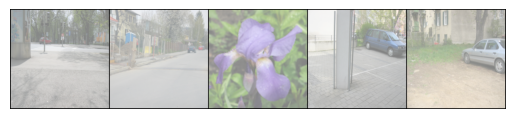

Validation Loss: 0.6967394709587097
Epoch: 37/100 Loss D: 0.6719924807548523, Loss G: 2.3000082969665527
Validation Loss: 0.6950164675712586
Epoch: 38/100 Loss D: 0.7072457075119019, Loss G: 2.4820094108581543
Validation Loss: 0.6944551110267639
Epoch: 39/100 Loss D: 0.6896498203277588, Loss G: 2.033599376678467
Validation Loss: 0.6954111218452453
Epoch: 40/100 Loss D: 0.6962883472442627, Loss G: 2.149042844772339
Validation Loss: 0.6949957489967347
Epoch: 41/100 Loss D: 0.6891043186187744, Loss G: 2.8767242431640625


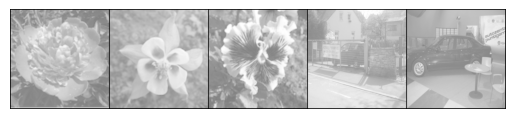

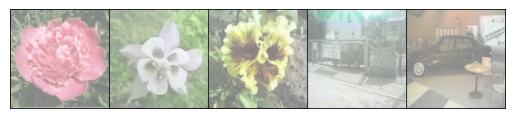

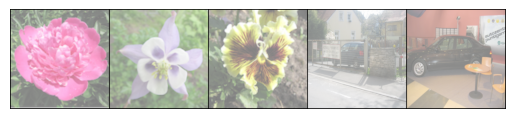

Validation Loss: 0.6945531487464904
Epoch: 42/100 Loss D: 0.665645956993103, Loss G: 2.473115921020508
Validation Loss: 0.6941185116767883
Epoch: 43/100 Loss D: 0.6593379974365234, Loss G: 2.490753650665283
Validation Loss: 0.6941473960876465
Epoch: 44/100 Loss D: 0.681251049041748, Loss G: 2.4913413524627686
Validation Loss: 0.6954562187194824
Epoch: 45/100 Loss D: 0.6658463478088379, Loss G: 2.3975095748901367
Validation Loss: 0.6937247157096863
Epoch: 46/100 Loss D: 0.6863413453102112, Loss G: 2.196084499359131


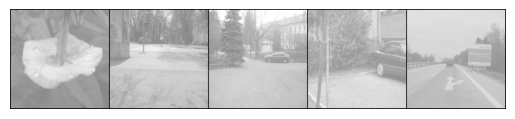

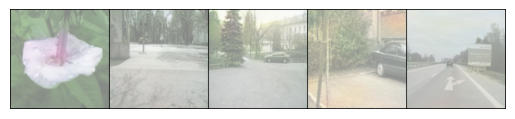

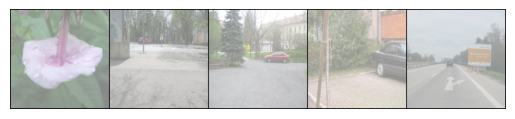

Validation Loss: 0.6941347479820251
Epoch: 47/100 Loss D: 0.6770783066749573, Loss G: 2.3489882946014404
Validation Loss: 0.6976698994636535
Epoch: 48/100 Loss D: 0.6656994819641113, Loss G: 2.2609150409698486
Validation Loss: 0.6932940006256103
Epoch: 49/100 Loss D: 0.7000471949577332, Loss G: 2.6726057529449463
Validation Loss: 0.6942454814910889
Epoch: 50/100 Loss D: 0.6976661682128906, Loss G: 2.2276320457458496
Validation Loss: 0.6925317168235778
Epoch: 51/100 Loss D: 0.683201789855957, Loss G: 2.0455684661865234


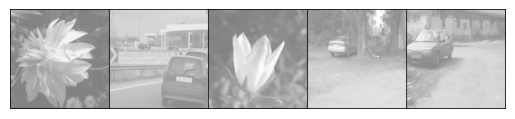

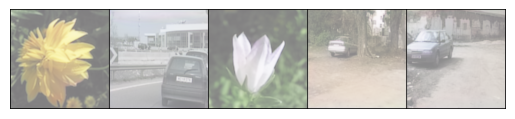

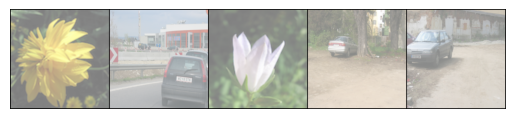

Validation Loss: 0.6931383848190308
Epoch: 52/100 Loss D: 0.6857528686523438, Loss G: 2.2223660945892334
Validation Loss: 0.6958733439445496
Epoch: 53/100 Loss D: 0.6858358979225159, Loss G: 2.602067470550537
Validation Loss: 0.6946711540222168
Epoch: 54/100 Loss D: 0.6569340825080872, Loss G: 2.627195119857788
Validation Loss: 0.6927554249763489
Epoch: 55/100 Loss D: 0.6779546737670898, Loss G: 2.60150146484375
Validation Loss: 0.6928165793418884
Epoch: 56/100 Loss D: 0.6819561123847961, Loss G: 1.9870063066482544


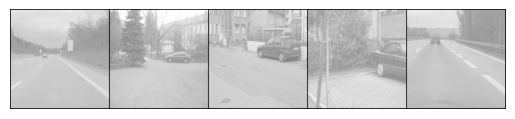

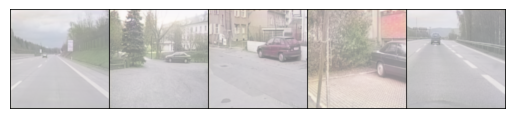

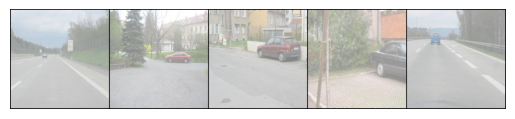

Validation Loss: 0.6961798191070556
Epoch: 57/100 Loss D: 0.6578757762908936, Loss G: 2.1539716720581055
Validation Loss: 0.6938345789909363
Epoch: 58/100 Loss D: 0.6876767873764038, Loss G: 2.504631519317627
Validation Loss: 0.6931227445602417
Epoch: 59/100 Loss D: 0.7101044654846191, Loss G: 2.1019515991210938
Validation Loss: 0.6943381547927856
Epoch: 60/100 Loss D: 0.7290904521942139, Loss G: 1.558945894241333
Validation Loss: 0.6942761063575744
Epoch: 61/100 Loss D: 0.6897269487380981, Loss G: 2.3026137351989746


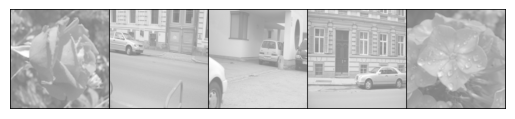

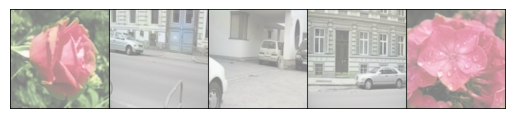

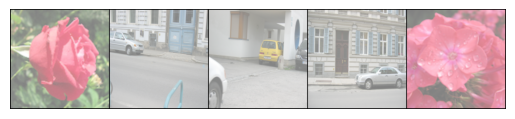

Validation Loss: 0.6949651598930359
Epoch: 62/100 Loss D: 0.6917882561683655, Loss G: 1.8750755786895752
Validation Loss: 0.6933758020401001
Epoch: 63/100 Loss D: 0.6916682720184326, Loss G: 2.483942985534668
Validation Loss: 0.6942846298217773
Epoch: 64/100 Loss D: 0.6914968490600586, Loss G: 2.286783218383789
Validation Loss: 0.6943336725234985
Epoch: 65/100 Loss D: 0.7162665724754333, Loss G: 2.6616177558898926
Validation Loss: 0.6933339238166809
Epoch: 66/100 Loss D: 0.6912257671356201, Loss G: 1.8511468172073364


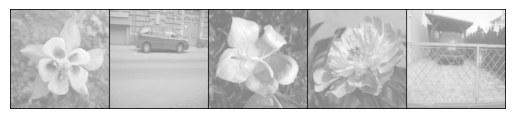

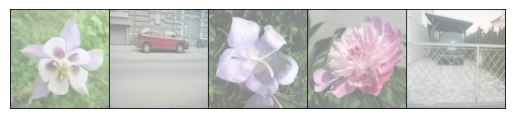

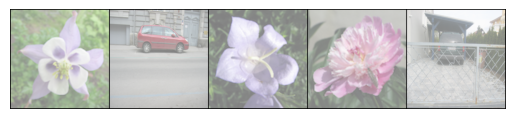

Validation Loss: 0.6945343613624573
Epoch: 67/100 Loss D: 0.7094211578369141, Loss G: 2.6758227348327637
Validation Loss: 0.6955854892730713
Epoch: 68/100 Loss D: 0.6850466728210449, Loss G: 1.8150702714920044
Validation Loss: 0.6955964922904968
Epoch: 69/100 Loss D: 0.6823254823684692, Loss G: 1.8968524932861328
Validation Loss: 0.6942897439002991
Epoch: 70/100 Loss D: 0.6897878646850586, Loss G: 1.9979615211486816
Validation Loss: 0.6934438824653626
Epoch: 71/100 Loss D: 0.6755338907241821, Loss G: 1.9096662998199463


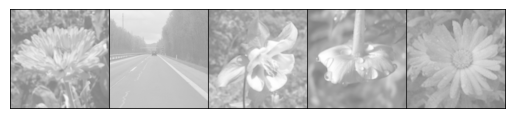

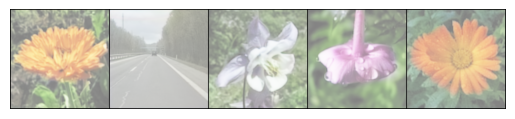

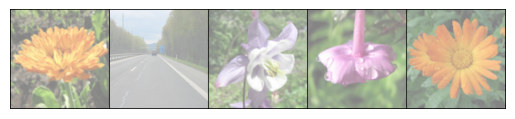

Validation Loss: 0.6935906171798706
Epoch: 72/100 Loss D: 0.674616813659668, Loss G: 1.9594533443450928
Validation Loss: 0.6942803382873535
Epoch: 73/100 Loss D: 0.6774590015411377, Loss G: 2.012897491455078
Validation Loss: 0.6940198183059693
Epoch: 74/100 Loss D: 0.6975351572036743, Loss G: 2.2086360454559326
Validation Loss: 0.6933299541473389
Epoch: 75/100 Loss D: 0.638558030128479, Loss G: 3.2333180904388428
Validation Loss: 0.6948837041854858
Epoch: 76/100 Loss D: 0.695110559463501, Loss G: 2.238165855407715


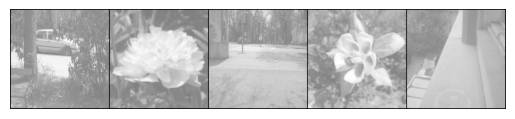

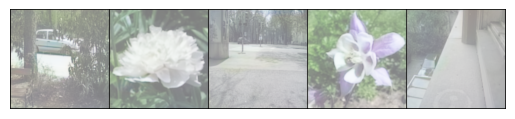

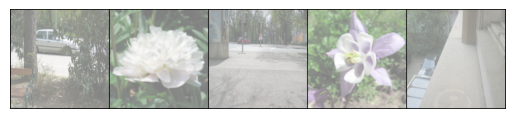

Validation Loss: 0.6959427475929261
Epoch: 77/100 Loss D: 0.6674861907958984, Loss G: 1.6486411094665527
Validation Loss: 0.6949668645858764
Epoch: 78/100 Loss D: 0.6682776212692261, Loss G: 1.9961509704589844
Validation Loss: 0.6944929003715515
Epoch: 79/100 Loss D: 0.6767783164978027, Loss G: 2.93280291557312
Validation Loss: 0.6947198867797851
Epoch: 80/100 Loss D: 0.6628403067588806, Loss G: 2.252290725708008
Validation Loss: 0.6924909472465515
Epoch: 81/100 Loss D: 0.6746000051498413, Loss G: 1.8479626178741455


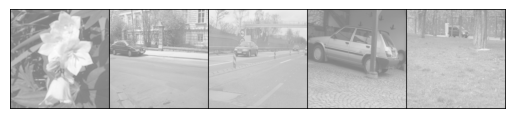

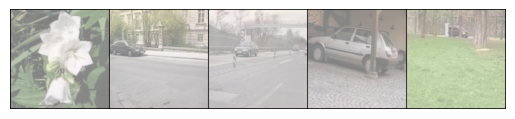

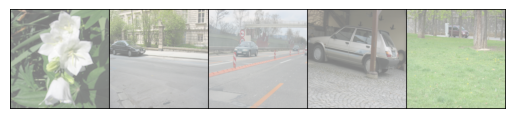

Validation Loss: 0.6942429780960083
Epoch: 82/100 Loss D: 0.6629394292831421, Loss G: 1.882120132446289
Validation Loss: 0.6955356359481811
Epoch: 83/100 Loss D: 0.7403519153594971, Loss G: 2.2614307403564453
Validation Loss: 0.6962139129638671
Epoch: 84/100 Loss D: 0.6352623701095581, Loss G: 1.588283658027649
Validation Loss: 0.6944486737251282
Epoch: 85/100 Loss D: 0.6204501986503601, Loss G: 1.800864338874817
Validation Loss: 0.695372712612152
Epoch: 86/100 Loss D: 0.6013736724853516, Loss G: 2.108854055404663


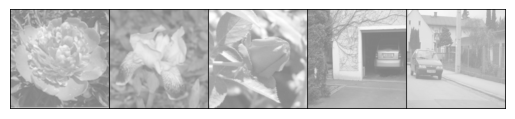

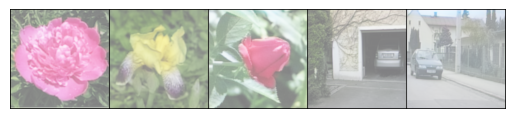

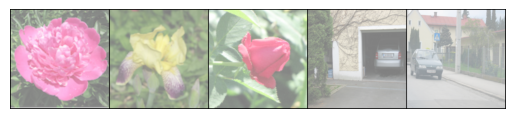

Validation Loss: 0.6952566742897034
Epoch: 87/100 Loss D: 0.6060321927070618, Loss G: 1.9739298820495605
Validation Loss: 0.6932917952537536
Epoch: 88/100 Loss D: 0.7335338592529297, Loss G: 2.4763193130493164
Validation Loss: 0.6940152049064636
Epoch: 89/100 Loss D: 0.5409436225891113, Loss G: 1.8596291542053223
Validation Loss: 0.6948873639106751
Epoch: 90/100 Loss D: 0.5612629652023315, Loss G: 2.0565459728240967
Validation Loss: 0.6946394801139831
Epoch: 91/100 Loss D: 0.53377765417099, Loss G: 1.418343424797058


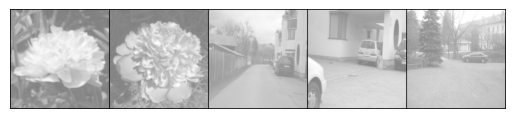

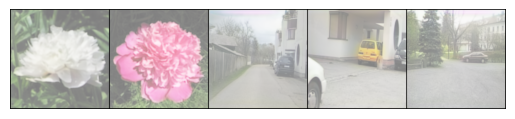

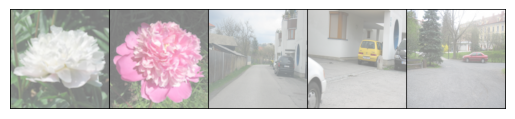

Validation Loss: 0.6960081100463867
Epoch: 92/100 Loss D: 0.6932196617126465, Loss G: 1.531470537185669
Validation Loss: 0.6951519131660462
Epoch: 93/100 Loss D: 0.5128875970840454, Loss G: 1.2987796068191528
Validation Loss: 0.6942839622497559
Epoch: 94/100 Loss D: 0.31956326961517334, Loss G: 1.1527460813522339
Validation Loss: 0.694173789024353
Epoch: 95/100 Loss D: 0.2606176435947418, Loss G: 1.3069134950637817
Validation Loss: 0.6931705713272095
Epoch: 96/100 Loss D: 0.24619698524475098, Loss G: 1.260435938835144


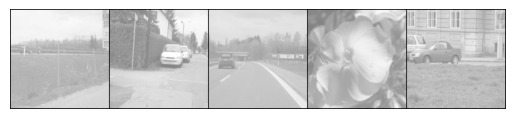

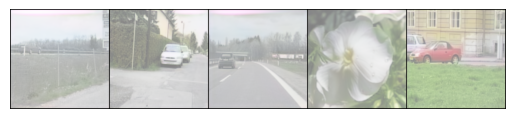

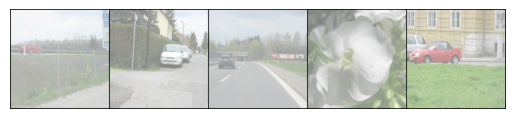

Validation Loss: 0.6964059114456177
Epoch: 97/100 Loss D: 0.2743905186653137, Loss G: 1.1719416379928589
Validation Loss: 0.6950845837593078
Epoch: 98/100 Loss D: 0.21092489361763, Loss G: 1.1065269708633423
Validation Loss: 0.6962213754653931
Epoch: 99/100 Loss D: 0.20321516692638397, Loss G: 1.3168549537658691
Validation Loss: 0.6948612093925476
Epoch: 100/100 Loss D: 0.22361387312412262, Loss G: 1.8872289657592773
Validation Loss: 0.6937635779380799


In [17]:
for epoch in range(num_epochs):
  discriminator.train()
  generator.train()
  for batch in train_loader:
    grey_batch = batch['grey'].to(device).float()
    colour_batch = batch['colour'].to(device).float()

    Disc_Loss = discriminator_training(grey_batch, colour_batch, discriminator_opt)

    Gen_Loss, generator_image = generator_training(grey_batch, colour_batch, generator_opt, L1_lambda)

  print(f"Epoch: {epoch+1}/{num_epochs} Loss D: {Disc_Loss}, Loss G: {Gen_Loss}")
  if (epoch % 5) == 0:
         print_images(grey_batch,5)
         print_images(generator_image,5)
         print_images(colour_batch,5)
  discriminator.eval()
  generator.eval()
  val_loss = 0
  with torch.no_grad():
    for batch in val_loader:
        grey_batch = batch['grey'].to(device).float()
        colour_batch = batch['colour'].to(device).float()

        fake_colour = generator(grey_batch)
        Gen_Loss = loss_comparison(fake_colour, colour_batch)

        val_loss += Gen_Loss.item()  # Validation kaybını toplama

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}")




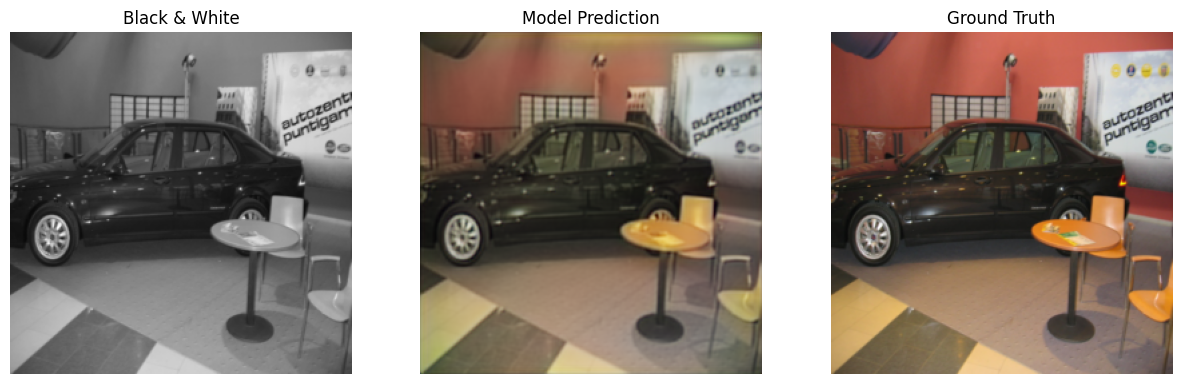

In [45]:
def imshow(image, title=None):
    """ Helper function to display an image tensor. """
    # image is a numpy array already
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# Test aşaması
generator.eval()
with torch.no_grad():
    # Get one batch from the test_loader
    for batch in train_loader:
        grey_batch = batch['grey'].to(device).float()
        colour_batch = batch['colour'].to(device).float()
        outputs = generator(grey_batch)

        # Take the first image in the batch
        grey_image = grey_batch[0]
        color_image = colour_batch[0]
        output_image = outputs[0]

        # Move tensors to CPU and normalize to [0, 1]
        grey_image = grey_image.cpu().numpy().transpose(1, 2, 0)
        grey_image = np.clip(grey_image, 0, 1)

        color_image = color_image.cpu().numpy().transpose(1, 2, 0)
        color_image = np.clip(color_image, 0, 1)

        output_image = output_image.cpu().numpy().transpose(1, 2, 0)
        output_image = np.clip(output_image, 0, 1)

        # Plotting
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        imshow(grey_image, 'Black & White')

        plt.subplot(1, 3, 2)
        imshow(output_image, 'Model Prediction')

        plt.subplot(1, 3, 3)
        imshow(color_image, 'Ground Truth')

        plt.show()
        break  # Only display the first example